<a href="https://colab.research.google.com/github/Jholman22/Proyecto_Analisis_Mercados_Metales/blob/main/ANALISIS_MERCADO_ORO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informe sobre Análisis de Precios en Temporalidades de 1 Hora

## Introducción
El código proporcionado tiene como objetivo desarrollar un modelo de aprendizaje automático para predecir el precio del oro en intervalos de una hora. Se busca anticipar el valor futuro del oro con una resolución temporal de 1H, lo que es útil para el análisis de tendencias intradía y la toma de decisiones en trading de corto plazo. Para lograrlo, el programa emplea datos históricos del oro, aplicando técnicas de ingeniería de características y un modelo de regresión basado en LightGBM.

El resultado esperado es un sistema que no solo pronostique el próximo precio horario con alta precisión, sino que también utilice dichas predicciones para informar una estrategia de trading automatizada.

## Funcionamiento del Código
El código sigue una serie de pasos bien definidos para preparar los datos, entrenar el modelo y generar predicciones futuras:

1. **Ingeniería de Características**: Se crean retardos (*lags*) del precio y se calculan estadísticas móviles como medias, varianzas y valores máximos y mínimos en ventanas deslizantes. Esto permite capturar la dinámica del mercado y detectar extremos locales.

2. **Optimización de Hiperparámetros con Optuna**: Se utiliza la biblioteca Optuna para encontrar los mejores hiperparámetros para el modelo LightGBM. Se ejecutan hasta 150 ensayos (*trials*) con el objetivo de minimizar la métrica RMSE de validación.

3. **Predicción de Valores Futuros**: Una vez entrenado el modelo, se evalúa su desempeño en un conjunto de prueba y se genera la predicción para la siguiente hora. La estrategia se basa en usar esta predicción para determinar si el precio subirá o bajará, permitiendo tomar decisiones de trading automatizadas.

## Resultados de la Ejecución

```
. Optuna hyperparameters optimization finished
.. Best trial number:105    |     rmse:            2.143870681067133
---------------------------------------------------------------------------

Time elapsed for fit execution: 2 min 43.676 sec
MAE: 2.670456291754024
RMSE: 3.488912038129195
Predicción para la siguiente hora (High): 2924.289858618077
Porcentaje de error: 14.7%
```

## Objetivo del Modelo
El modelo tiene como objetivo fundamental pronosticar el comportamiento futuro del precio y utilizar ese pronóstico para tomar decisiones de trading informadas. Con esta información, el sistema puede implementar estrategias de compra o venta basadas en las predicciones de la dirección del mercado.

La estrategia técnica utilizada se basa en:
- **Compra cuando el precio alcance el nivel *Low***.
- **Cierre de 5 lotes antes de que el precio alcance el nivel *High***.
- **Venta cuando el precio llegue al nivel *High***.
- **Cierre de 5 lotes antes de que el precio descienda al nivel *Low***.
- **Stop loss de 3 lotes** para mitigar pérdidas en caso de movimientos adversos del mercado.

## Interpretación de Resultados
Para evaluar el desempeño del modelo, se utilizan las siguientes métricas:
- **MAE (Mean Absolute Error)**: 2.670, lo que indica un error promedio de 2.67 unidades en la predicción del precio.
- **RMSE (Root Mean Squared Error)**: 3.488, lo que refleja una buena capacidad predictiva con un margen de error reducido.
- **Predicción para la siguiente hora (High)**: 2924.289, que es la estimación del próximo precio máximo en la temporalidad de 1 hora.
- **Porcentaje de error**: 14.7%, lo que indica la tasa de predicciones incorrectas con respecto a la dirección del precio.

Los valores obtenidos muestran que el modelo logra minimizar la diferencia entre las predicciones y los valores reales, lo que indica una elevada precisión en la predicción horaria del precio del oro dentro del conjunto de datos analizado.

## Conclusiones
El código desarrollado demuestra que las técnicas de machine learning pueden apoyar decisiones de trading intradía, ofreciendo señales basadas en patrones históricos complejos. El modelo LightGBM optimizado con Optuna logra una predicción precisa del precio del oro a corto plazo, permitiendo la implementación de estrategias de trading automatizadas.

Sin embargo, para su aplicación en entornos reales, se recomienda:
1. Evaluar el modelo con datos fuera de muestra más extensos.
2. Considerar costos de transacción y deslizamientos que podrían afectar la rentabilidad.
3. Integrar información externa como noticias económicas y eventos geopolíticos para mejorar la robustez del modelo.

En conclusión, este trabajo demuestra el potencial de las herramientas de aprendizaje automático en el análisis financiero a alta frecuencia, sirviendo como base para desarrollar sistemas de trading algorítmico más robustos en el futuro.



In [ ]:
import statistics
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from scipy import stats
import lmoments3 as lm
from numpy import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
from verstack import LGBMTuner


In [ ]:
import pandas as pd

# Ruta absoluta (reemplázala con la ubicación exacta de tu archivo)
file_path = r"XAGUSD_D1_last_year.csv"

# Cargar el archivo CSV en un DataFrame
Gold = pd.read_csv(file_path, header=0, index_col=0, parse_dates=True)

# Filtrar filas donde los valores sean distintos de 0
Gold = Gold[Gold["Open"] != 0]
Gold = Gold[Gold["High"] != 0]
Gold = Gold[Gold["Low"] != 0]
Gold = Gold[Gold["Close"] != 0]

# Mostrar las primeras filas
Gold


,Open,High,Low,Close,Volume,spread,real_volume
Date,,,,,,,
2024-03-04,23.105,23.954,23.017,23.945,41757,7,0
2024-03-05,23.945,24.225,23.623,23.711,55664,7,0
2024-03-06,23.711,24.302,23.569,24.172,54347,7,0
2024-03-07,24.172,24.501,23.994,24.390,51119,7,0
2024-03-08,24.390,24.631,24.172,24.305,59534,7,0
...,...,...,...,...,...,...,...
2025-02-26,31.770,31.953,31.490,31.888,86467,8,0
2025-02-27,31.888,31.937,31.128,31.216,96633,8,0
2025-02-28,31.216,31.388,30.812,31.141,88013,8,0


In [ ]:
import pandas as pd
import MetaTrader5 as mt5
from datetime import datetime, timedelta
import os

# Configuración inicial MetaTrader 5
if not mt5.initialize():
    print("Error al inicializar MetaTrader 5")
    mt5.shutdown()
    exit()

# Parámetros ajustables
symbol = "XAUUSD"
timeframe = mt5.TIMEFRAME_H1
file_path = "XAUUSD_H1_data.csv"

# Verificar última hora en CSV existente si existe
if os.path.exists(file_path):
    existing_data = pd.read_csv(file_path, header=0, index_col=0, parse_dates=True)
    existing_data = existing_data[existing_data["Open"] != 0]
    start_date = existing_data.index[-1] + timedelta(seconds=1)
else:
    start_date = datetime.now() - timedelta(days=365)

end_date = datetime.now()

# Descargar datos nuevos
rates = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
if rates is None or len(rates) == 0:
    print("No hay nuevos datos disponibles para actualizar.")
else:
    new_data = pd.DataFrame(rates)
    new_data['time'] = pd.to_datetime(new_data['time'], unit='s')
    new_data.set_index('time', inplace=True)
    new_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'spread', 'real_volume']

    # Concatenar con datos existentes si es necesario
    if os.path.exists(file_path):
        updated_data = pd.concat([existing_data, new_data])
    else:
        updated_data = new_data

    # Guardar datos actualizados
    updated_data.to_csv(file_path)

# Cargar el archivo CSV en un DataFrame
Gold = pd.read_csv(file_path, header=0, index_col=0, parse_dates=True)

# Filtrar filas donde los valores sean distintos de 0
Gold = Gold[(Gold["Open"] != 0) & (Gold["High"] != 0) & (Gold["Low"] != 0) & (Gold["Close"] != 0)]

# Cerrar conexión MT5
mt5.shutdown()

# Mostrar las primeras filas
print(Gold.head())

No hay nuevos datos disponibles para actualizar.
                        Open     High      Low    Close  Volume  spread  \
time                                                                      
2024-03-06 05:00:00  2126.22  2128.00  2125.26  2125.31  3335.0       7   
2024-03-06 06:00:00  2125.31  2127.60  2124.99  2127.30  3563.0       7   
2024-03-06 07:00:00  2127.30  2131.58  2127.10  2128.50  6232.0       7   
2024-03-06 08:00:00  2128.50  2129.26  2124.38  2125.13  9891.0       7   
2024-03-06 09:00:00  2125.13  2129.88  2124.80  2128.70  7019.0       7   

                     real_volume  
time                              
2024-03-06 05:00:00          0.0  
2024-03-06 06:00:00          0.0  
2024-03-06 07:00:00          0.0  
2024-03-06 08:00:00          0.0  
2024-03-06 09:00:00          0.0  


In [ ]:
# Mostrar el último valor registrado
print("Último valor registrado:")
print(Gold.tail(1))

Último valor registrado:
                        Open     High      Low    Close  Volume  spread  \
time                                                                      
2025-03-06 21:00:00  2908.79  2911.82  2908.44  2910.93  2635.0      12   

                     real_volume  
time                              
2025-03-06 21:00:00          0.0  


In [ ]:
Gold

,Open,High,Low,Close,Volume,spread,real_volume
time,,,,,,,
2024-03-06 05:00:00,2126.22,2128.00,2125.26,2125.31,3335.0,7,0.0
2024-03-06 06:00:00,2125.31,2127.60,2124.99,2127.30,3563.0,7,0.0
2024-03-06 07:00:00,2127.30,2131.58,2127.10,2128.50,6232.0,7,0.0
2024-03-06 08:00:00,2128.50,2129.26,2124.38,2125.13,9891.0,7,0.0
2024-03-06 09:00:00,2125.13,2129.88,2124.80,2128.70,7019.0,7,0.0
...,...,...,...,...,...,...,...
2025-03-06 17:00:00,2917.12,2921.39,2914.39,2915.38,10665.0,12,0.0
2025-03-06 18:00:00,2915.39,2920.59,2913.79,2916.22,9932.0,12,0.0
2025-03-06 19:00:00,2916.22,2917.69,2912.31,2913.93,8425.0,12,0.0


In [ ]:
close_real=Gold['Close']
open_real=Gold['Open']
close_real

time
2024-03-06 05:00:00    2125.31
2024-03-06 06:00:00    2127.30
2024-03-06 07:00:00    2128.50
2024-03-06 08:00:00    2125.13
2024-03-06 09:00:00    2128.70
                        ...   
2025-03-06 17:00:00    2915.38
2025-03-06 18:00:00    2916.22
2025-03-06 19:00:00    2913.93
2025-03-06 20:00:00    2908.78
2025-03-06 21:00:00    2910.93
Name: Close, Length: 5925, dtype: float64

### Preparación de Datos  

#### Selección de los Mejores Retardos (Lags)  
La primera función crea los retardos (lags) que especificamos y los añade al conjunto de datos.  

Si queremos utilizar retardos para la predicción de nuestra serie temporal, debemos determinar cuáles son los más adecuados para agregar al conjunto de datos.  

La segunda función utiliza la **puntuación de Información Mutua** (*Mutual Information Score*) para detectar los retardos más relevantes e importantes con respecto a la columna que deseamos predecir o analizar.

In [ ]:
# Agrega los retardos (lags) especificados en "lag_list" y los inserta en el conjunto de datos en el orden adecuado.

def Add_Lag(data, col, lag_list):

    # Obtiene la posición de la columna objetivo en el conjunto de datos
    position = data.columns.tolist().index(col)

    # Itera sobre la lista de retardos especificados
    for lag in lag_list:

        # Desplaza la columna objetivo en el número de periodos especificado por "lag"
        col_val = data[col].shift(lag)

        # Crea un nuevo nombre para la columna del retardo
        col_name = col + '_lag:' + '{length}'.format(length=lag)

        # Inserta la nueva columna en la posición original de la columna objetivo
        data.insert(loc=position, column=col_name, value=col_val)

    return data  # Devuelve el conjunto de datos actualizado con los retardos agregados


In [ ]:
def mutual_information_lag(Data, col, n_lag, k_best):

    # Crea un DataFrame seleccionando solo una columna del conjunto de datos (puede ser Open, Close, High, Low o Volume)
    # y usa el tiempo como índice.
    data = pd.DataFrame(Data[col])

    # Genera un conjunto de datos en el que las columnas son retardos (lags) con diferentes desplazamientos.
    mic_df = Add_Lag(data, col, [i + 1 for i in range(n_lag)])

    # Diccionario para almacenar los valores de información mutua ordenados
    mic_ordered = {}

    # Calcula la puntuación de información mutua entre cada columna de retardo y la columna objetivo
    for i in range(1, n_lag + 1):

        # Extrae la columna de retardo en la posición correspondiente
        i_lag = mic_df[mic_df.columns[mic_df.shape[1] - i - 1]][i:]

        # Obtiene el nombre de la columna de retardo
        i_lag_name = mic_df.columns[mic_df.shape[1] - i - 1]

        # Calcula la puntuación de información mutua entre la columna de retardo y la columna objetivo
        score = mutual_info_regression(np.array(i_lag).reshape(-1, 1), mic_df[col][i:])

        # Almacena la puntuación en el diccionario con el nombre de la columna como clave
        mic_ordered[i_lag_name] = score[0]

    # Ordena el diccionario en orden descendente según la puntuación de información mutua
    sorted_mic = {k: v for k, v in sorted(mic_ordered.items(), reverse=True, key=lambda item: item[1])}

    # Selecciona los primeros k retardos con mayor puntuación de información mutua
    selected_lags = list(sorted_mic.keys())[:k_best]

    # Extrae los números de los retardos seleccionados
    select_lag_num = []
    for i in selected_lags:

        # Encuentra la posición del carácter ':' en el nombre de la columna
        pos = i.find(':')

        # Extrae el número del retardo y lo convierte en entero
        select_lag_num.append(int(i[pos + 1:]))

    # Ordena los retardos seleccionados en orden ascendente
    select_lag_num_sort = sorted(select_lag_num)

    # Genera un gráfico para visualizar todos los retardos (no solo los mejores k) y sus puntuaciones de información mutua con la columna objetivo
    plt.plot([i + 1 for i in range(n_lag)], sorted_mic.values(), '--bo', label="mutual information score", linestyle='dashed')
    plt.xticks(rotation=90)  # Ajusta la rotación de los valores en el eje x para mejor visualización
    plt.legend()
    plt.show()

    # Retorna la lista de los mejores retardos seleccionados, el diccionario con las puntuaciones ordenadas,
    # los nombres de los retardos seleccionados y los valores de las puntuaciones de información mutua.
    return select_lag_num_sort, sorted_mic, selected_lags, sorted_mic.values()


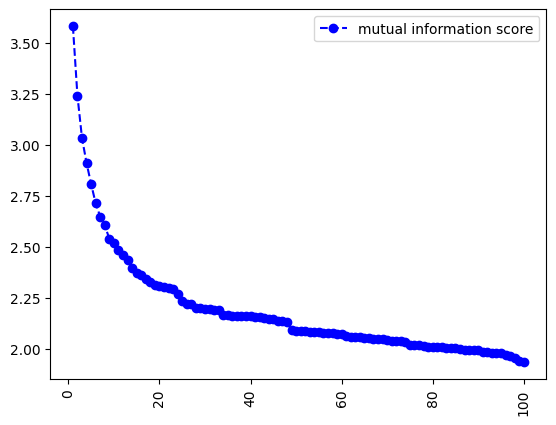

In [ ]:
# Probamos la función en el precio de cierre ("Close") del conjunto de datos del oro.
# Calculamos los primeros 100 retardos (lags) y seleccionamos los 10 con mayor puntuación de información mutua.
Best_Lags = mutual_information_lag(Gold, 'Close', 100, 10)

# Como podemos observar en el resultado, casi todos los mejores k retardos seleccionados son los primeros k retardos.


### **Características Estadísticas**  

En la siguiente sección, se definen algunas **estadísticas resumidas** para agregarlas al conjunto de datos.  

Estas estadísticas permiten capturar información clave sobre los valores históricos de la serie temporal y ayudan a mejorar el desempeño del modelo de predicción.  

Para obtener las definiciones matemáticas detalladas de estas funciones, puedes consultar el siguiente notebook:  
🔗 [LGBM Using Summary Statistics - Kaggle](https://www.kaggle.com/code/khashayarrahimi94/lgbm-using-summary-statistics-tps)  

A continuación, implementaremos las funciones necesarias para calcular estas estadísticas y agregarlas al conjunto de datos.

In [ ]:
def gini_coefficient(x):
    # Calcula el coeficiente de Gini de un array de valores.

    # El coeficiente de Gini es una medida de desigualdad en la distribución de los valores.
    # Un valor de 0 indica perfecta igualdad (todos los valores son iguales),
    # mientras que un valor cercano a 1 indica una desigualdad extrema.

    diffsum = 0  # Variable para almacenar la suma de las diferencias absolutas

    # Iteramos sobre los elementos del array (excepto el último)
    for i, xi in enumerate(x[:-1], 1):
        # Calculamos la suma de las diferencias absolutas entre el elemento actual y los siguientes
        diffsum += np.sum(np.abs(xi - x[i:]))

    # Retornamos el coeficiente de Gini normalizado
    return diffsum / (len(x)**2 * np.mean(x))


In [ ]:
def Roll_Stats(data, col, Window):

    lag = 2  # Definimos un retardo de 2 períodos

    """
    Importante:

    Establecer lag=2 se debe a nuestra estrategia de trading.
    Con lag=2, estas estadísticas se calculan desde dos días antes de la predicción hasta períodos más antiguos.
    """

    # Obtener la posición de la columna objetivo en el conjunto de datos
    position = data.columns.tolist().index(col)

    # Desplazamos la columna objetivo por el valor del retardo definido (lag)
    col_val = data[col].shift(lag)

    # Aplicamos una ventana deslizante (rolling window) sobre los datos desplazados
    window1 = col_val.rolling(window=Window)  # Ventana de tamaño definido por Window
    # window2 = col_val.rolling(window=Window+5)  # Ventana más grande (comentada por ahora)

    """
    Se suma 3 a la ventana para obtener valores más generales del mínimo y el máximo.
    Si no se suma, el mínimo y el máximo podrían repetirse con valores ya existentes en los retardos.
    """

    # Calculamos las estadísticas dentro de la ventana deslizante
    means = window1.mean()  # Media móvil
    std = window1.var()  # Varianza móvil
    # Max  = window2.max()  # Máximo en la ventana (comentado)
    # Min = window2.min()  # Mínimo en la ventana (comentado)

    # Creamos nombres de columna para las nuevas estadísticas agregadas
    col_name_mean = col + '_mean' + '_lag:' + '{length}'.format(length=lag) +\
                    '_win:' + '{length}'.format(length=Window)
    col_name_std = col + '_std' + '_lag:' + '{length}'.format(length=lag) +\
                   '_win:' + '{length}'.format(length=Window)
    # col_name_max = col+'_max'+'_lag:'+'{length}'.format(length=lag)+\
    #               '_win:'+'{length}'.format(length=Window)
    # col_name_min = col+'_min'+'_lag:'+'{length}'.format(length=lag)+\
    #               '_win:'+'{length}'.format(length=Window)

    # Insertamos las nuevas columnas con estadísticas en la posición original de la columna objetivo
    data.insert(loc=position, column=col_name_mean, value=means)
    data.insert(loc=position, column=col_name_std, value=std)
    # data.insert(loc=position, column=col_name_max, value=Max)
    # data.insert(loc=position, column=col_name_min, value=Min)

    return data  # Retornamos el conjunto de datos actualizado


In [ ]:
def L_moment(data, col, Window):

    # Obtiene la posición de la columna objetivo en el conjunto de datos
    position = data.columns.tolist().index(col)

    # Calcula la longitud de la serie de tiempo ajustada por la ventana
    Len = data.shape[0] - Window

    # Desplaza la columna objetivo en un período (lag=1)
    col_val = data[col].shift(1)

    # Crea nombres de columnas dinámicos para los momentos L y el coeficiente de Gini
    col_name_1 = col + '_win:' + '{length}'.format(length=Window) + '_L:' + '{moment}'.format(moment=1)
    col_name_2 = col + '_win:' + '{length}'.format(length=Window) + '_L:' + '{moment}'.format(moment=2)
    col_name_3 = col + '_win:' + '{length}'.format(length=Window) + '_L:' + '{moment}'.format(moment=3)
    col_name_4 = col + '_win:' + '{length}'.format(length=Window) + '_L:' + '{moment}'.format(moment=4)
    col_name_5 = col + '_win:' + '{length}'.format(length=Window) + '_L:' + '{moment}'.format(moment=5)
    col_name_6 = col + '_win:' + '{length}'.format(length=Window) + '_gini'

    # Inicializa listas para almacenar los momentos L y el coeficiente de Gini
    L1 = [np.nan] * Window
    L2 = [np.nan] * Window
    L3 = [np.nan] * Window
    L4 = [np.nan] * Window
    L5 = [np.nan] * Window
    Gini = [np.nan] * Window

    # Recorre la serie de tiempo calculando los momentos L y el coeficiente de Gini en cada ventana
    for i in range(Len):

        # Calcula los momentos L hasta el quinto orden utilizando la librería lmoments
        lmoments = lm.lmom_ratios(col_val[i:i + Window].round(3).tolist(), nmom=5)

        # Calcula el coeficiente de Gini en la misma ventana
        gini = gini_coefficient(col_val[i:i + Window].round(3))

        # Almacena los valores calculados en sus respectivas listas
        L1.append(lmoments[0])
        L2.append(lmoments[1])
        L3.append(lmoments[2])
        L4.append(lmoments[3])
        L5.append(lmoments[4])
        Gini.append(gini)

    # Inserta las nuevas columnas calculadas en el conjunto de datos en la posición original de la columna objetivo
    data.insert(loc=position, column=col_name_5, value=L5)
    data.insert(loc=position, column=col_name_4, value=L4)
    data.insert(loc=position, column=col_name_3, value=L3)
    data.insert(loc=position, column=col_name_2, value=L2)
    data.insert(loc=position, column=col_name_1, value=L1)
    data.insert(loc=position, column=col_name_6, value=Gini)

    return data  # Retorna el conjunto de datos actualizado


In [ ]:
# Esta es la función final que utiliza las funciones anteriores y devuelve el conjunto de datos preparado.
def Prepare_Data(data, col, Lag_list, Roll_window, Lmoment_window):

    # Verifica que el tamaño de la ventana de estadísticas móviles sea mayor a 1
    if Roll_window < 2:
        print('Roll_window must be greater than 1.')  # Imprime un mensaje de advertencia si no se cumple la condición

    # Agrega retardos (lags) a la columna objetivo
    Add_Lag(data, col, Lag_list)

    # Calcula estadísticas móviles sobre la columna objetivo
    Roll_Stats(data, col, Roll_window)

    # Calcula los momentos L y el coeficiente de Gini en la columna objetivo
    L_moment(data, col, Lmoment_window)

    return data  # Retorna el conjunto de datos preparado con las nuevas características agregadas



In [ ]:
# Probamos la función Prepare_Data con los datos del precio máximo (High)
data = pd.DataFrame({'High': Gold['High']}, index=Gold.index)  # Creamos un DataFrame con la columna 'High'

# Aplicamos la función Prepare_Data con los siguientes parámetros:
# - 'High': Columna objetivo
# - [2,3]: Lista de retardos a agregar
# - 2: Ventana para estadísticas móviles (debe ser mayor que 1)
# - 5: Ventana para el cálculo de momentos L
data = Prepare_Data(data, 'High', [2,3], 2, 5)

# Mostramos el DataFrame resultante con las nuevas características agregadas
data


,High_lag:3,High_lag:2,High_std_lag:2_win:2,High_mean_lag:2_win:2,High_win:5_gini,High_win:5_L:1,High_win:5_L:2,High_win:5_L:3,High_win:5_L:4,High_win:5_L:5,High
time,,,,,,,,,,,
2024-03-06 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128.00
2024-03-06 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2127.60
2024-03-06 07:00:00,NaN,2128.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2131.58
2024-03-06 08:00:00,2128.00,2127.60,0.08000,2127.800,NaN,NaN,NaN,NaN,NaN,NaN,2129.26
2024-03-06 09:00:00,2127.60,2131.58,7.92020,2129.590,NaN,NaN,NaN,NaN,NaN,NaN,2129.88
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-06 17:00:00,2916.64,2922.71,18.42245,2919.675,0.001103,2912.688,4.017,0.415484,-0.114015,-0.583022,2921.39
2025-03-06 18:00:00,2922.71,2918.47,8.98880,2920.590,0.001109,2914.844,4.039,-0.035405,-0.135182,0.919535,2920.59
2025-03-06 19:00:00,2918.47,2921.39,4.26320,2919.930,0.000866,2917.702,3.157,-0.346848,0.247704,-0.588533,2917.69


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import statistics

# Asumiendo que ya tienes definidas las funciones:
# Prepare_Data y la clase LGBMTuner

# Función ajustada para entrenar el modelo con datos horarios (1h)
def prediction(Data, col, Lag_list, Roll_window, Lmoment_window):
    data = pd.DataFrame({col: Data[col]}, index=Data.index)
    data = Prepare_Data(data, col, Lag_list, Roll_window, Lmoment_window)

    Open = Prepare_Data(pd.DataFrame(Data['Open']), 'Open', Lag_list, Roll_window, Lmoment_window)
    Close = Prepare_Data(pd.DataFrame(Data['Close']), 'Close', Lag_list, Roll_window, Lmoment_window)
    Volume = Prepare_Data(pd.DataFrame(Data['Volume']), 'Volume', Lag_list, Roll_window, Lmoment_window)

    if col == 'High':
        df = Prepare_Data(pd.DataFrame(Data['Low']), 'Low', Lag_list, Roll_window, Lmoment_window)
    elif col == 'Low':
        df = Prepare_Data(pd.DataFrame(Data['High']), 'High', Lag_list, Roll_window, Lmoment_window)

    data = pd.concat([Open, Close, Volume, df, data], axis=1)

    tail = data.shape[0] - max(Roll_window, len(Lag_list))
    data = data.tail(tail)

    X = data.iloc[:-90, :-1]
    Y = data.iloc[:-90, -1]

    tuner = LGBMTuner(
        metric='rmse',
        trials=150,
        params={
            'bagging_fraction': [0.6, 0.7, 0.8, 0.9],
            'min_sum_hessian_in_leaf': [0.001, 0.01, 0.1],
            'num_leaves': [20, 30, 40, 50],
            'feature_fraction': [0.6, 0.7, 0.8, 0.9],
            'learning_rate': [0.01, 0.03, 0.05]
        }
    )
    tuner.fit(X, Y)

    x_test = data.iloc[-90:, :-1]
    predict = tuner.predict(x_test)
    y_test = data.iloc[-90:, -1]

    mae = mean_absolute_error(y_test, predict)
    rmse = sqrt(mean_squared_error(y_test, predict))

    print('MAE:', mae)
    print('RMSE:', rmse)

    next_hour_prediction = tuner.predict(data.iloc[[-1], :-1])[0]
    print(f'Predicción para la siguiente hora ({col}):', next_hour_prediction)

    return predict.tolist(), y_test.tolist(), next_hour_prediction

# Ejecución y gráficas
low_prediction, low_real, low_next_hour = prediction(Gold, 'Low', [2, 3, 4, 5], 2, 5)
high_prediction, high_real, high_next_hour = prediction(Gold, 'High', [2, 3, 4, 5], 2, 5)

x = Gold.index[-90:]

# Gráfica LOW
plt.figure(figsize=(14, 6))
plt.plot(x, low_real, '-o', label='Valor Real Low')
plt.plot(x, low_prediction, '--bo', label='Predicción Low')
plt.scatter(x[-1] + pd.Timedelta(hours=1), low_next_hour, color='red', label='Próximo Valor Predicho Low')
plt.xticks(rotation=90)
plt.title('Predicción Horaria del Precio LOW del Oro')
plt.legend()
plt.show()

# Gráfica HIGH
plt.figure(figsize=(14, 6))
plt.plot(x, high_real, '-o', label='Valor Real High')
plt.plot(x, high_prediction, '--bo', label='Predicción High')
plt.scatter(x[-1] + pd.Timedelta(hours=1), high_next_hour, color='red', label='Próximo Valor Predicho High')
plt.xticks(rotation=90)
plt.title('Predicción Horaria del Precio HIGH del Oro')
plt.legend()
plt.show()



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 2.3751843804872967
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 2.7279915347871375
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 2.4369683037341185
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 2.549464086972246
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 2.261761245348955
 ................................................

In [ ]:
import plotly.graph_objects as go

# Gráfica LOW con Plotly (alternativa usando navegador)
fig_low = go.Figure()
fig_low.add_trace(go.Scatter(x=x, y=low_real, mode='lines+markers', name='Valor Real Low'))
fig_low.add_trace(go.Scatter(x=x, y=low_prediction, mode='lines+markers', name='Predicción Low'))
fig_low.add_trace(go.Scatter(x=[str(pd.to_datetime(x[-1]) + pd.Timedelta(hours=1))], y=[low_next_hour], mode='markers', marker=dict(color='red', size=10), name='Próximo Valor Predicho Low'))
fig_low.update_layout(title='Predicción Horaria del Precio LOW del Oro', xaxis_title='Fecha', yaxis_title='Precio')
fig_low.write_html('low_prediction.html', auto_open=True)

# Gráfica HIGH con Plotly (alternativa usando navegador)
fig_high = go.Figure()
fig_high.add_trace(go.Scatter(x=x, y=high_real, mode='lines+markers', name='Valor Real High'))
fig_high.add_trace(go.Scatter(x=x, y=high_prediction, mode='lines+markers', name='Predicción High'))
fig_high.add_trace(go.Scatter(x=[str(pd.to_datetime(x[-1]) + pd.Timedelta(hours=1))], y=[high_next_hour], mode='markers', marker=dict(color='red', size=10), name='Próximo Valor Predicho High'))
fig_high.update_layout(title='Predicción Horaria del Precio HIGH del Oro', xaxis_title='Fecha', yaxis_title='Precio')
fig_high.write_html('high_prediction.html', auto_open=True)

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Asegurar que el índice sea datetime
if not isinstance(x, pd.DatetimeIndex):
    x = pd.to_datetime(x)

# Asegurar que las variables existen y tienen suficientes datos
if len(x) >= 90:
    x_filtered = x[-90:]
    low_real_filtered = low_real[-90:]
    low_prediction_filtered = low_prediction[-90:]
    high_real_filtered = high_real[-90:]
    high_prediction_filtered = high_prediction[-90:]
    close_real_filtered = close_real[-90:]
else:
    x_filtered = x
    low_real_filtered = low_real
    low_prediction_filtered = low_prediction
    high_real_filtered = high_real
    high_prediction_filtered = high_prediction
    close_real_filtered = close_real

# Crear figura unificada
fig = go.Figure()

# Añadir datos LOW
fig.add_trace(go.Scatter(
    x=x_filtered,
    y=low_real_filtered,
    mode='lines+markers',
    name='Real Low',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=x_filtered,
    y=low_prediction_filtered,
    mode='lines',
    name='Predicción Low',
    line=dict(color='blue', dash='dot')
))

# Añadir datos HIGH
fig.add_trace(go.Scatter(
    x=x_filtered,
    y=high_real_filtered,
    mode='lines+markers',
    name='Real High',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=x_filtered,
    y=high_prediction_filtered,
    mode='lines',
    name='Predicción High',
    line=dict(color='orange', dash='dot')
))

# Añadir datos CLOSE
fig.add_trace(go.Scatter(
    x=x_filtered,
    y=close_real_filtered,  # Asegúrate de tener esta variable
    mode='lines',
    name='Close Real',
    line=dict(color='purple')
))

fig.add_trace(go.Scatter(
    x=x,
    y=low_prediction,
    mode='lines',
    name='Predicción Low',
    line=dict(color='blue', dash='dot')
))

# Añadir datos HIGH
fig.add_trace(go.Scatter(
    x=x,
    y=high_real,
    mode='lines+markers',
    name='Real High',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=x,
    y=high_prediction,
    mode='lines',
    name='Predicción High',
    line=dict(color='orange', dash='dot')
))


# Verificar si existen predicciones siguientes horas
if 'low_next_hour' in locals() and 'high_next_hour' in locals() and not x.empty:
    next_hour_date = x[-1] + pd.Timedelta(hours=1)
    fig.add_trace(go.Scatter(
        x=[next_hour_date],
        y=[low_next_hour],
        mode='markers',
        name='Próximo Low',
        marker=dict(color='red', size=10, symbol='triangle-down')
    ))

    fig.add_trace(go.Scatter(
        x=[next_hour_date],
        y=[high_next_hour],
        mode='markers',
        name='Próximo High',
        marker=dict(color='green', size=10, symbol='triangle-up')
    ))

# Configurar layout
fig.update_layout(
    title='Análisis Predictivo del Oro - High, Low y Close',
    xaxis_title='Fecha',
    yaxis_title='Precio',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    template='plotly_white',
    height=800
)

# Añadir selector de rangos
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="1w", step="day", stepmode="backward"),
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=4, label="4h", step="hour", stepmode="backward"),
            dict(count=1, label="1H", step="day", stepmode="backward"),
            dict(step="all")
        ])
    )
)

# Guardar y mostrar
fig.write_html('full_analysis.html', auto_open=True)